In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1t2_native_k5_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 198)
(631390, 1)
validation
(74368, 198)
(74368, 1)
test
(85358, 198)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 198)]             0         


 dense (Dense)               (None, 1024)              203776    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 892929 (3.41 MB)


Trainable params: 892929 (3.41 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:28 - loss: 0.1809 - STD: 7.5347e-05 - MAE: 0.4131

 5/64 [=>............................] - ETA: 0s - loss: 0.0574 - STD: 8.7302e-05 - MAE: 0.1812  

10/64 [===>..........................] - ETA: 0s - loss: 0.0473 - STD: 5.4766e-05 - MAE: 0.1692

15/64 [======>.......................] - ETA: 0s - loss: 0.0410 - STD: 3.8635e-05 - MAE: 0.1542

19/64 [=======>......................] - ETA: 0s - loss: 0.0354 - STD: 3.1275e-05 - MAE: 0.1363

24/64 [==========>...................] - ETA: 0s - loss: 0.0315 - STD: 2.5538e-05 - MAE: 0.1311

28/64 [============>.................] - ETA: 0s - loss: 0.0291 - STD: 2.2605e-05 - MAE: 0.1264

32/64 [==============>...............] - ETA: 0s - loss: 0.0271 - STD: 2.0615e-05 - MAE: 0.1188

37/64 [================>.............] - ETA: 0s - loss: 0.0253 - STD: 1.8885e-05 - MAE: 0.1109

42/64 [==================>...........] - ETA: 0s - loss: 0.0239 - STD: 1.7713e-05 - MAE: 0.1053

47/64 [=====================>........] - ETA: 0s - loss: 0.0227 - STD: 1.6942e-05 - MAE: 0.1025

52/64 [=======================>......] - ETA: 0s - loss: 0.0218 - STD: 1.6448e-05 - MAE: 0.1003

53/64 [=======================>......] - ETA: 0s - loss: 0.0218 - STD: 1.6368e-05 - MAE: 0.0998

58/64 [==========================>...] - ETA: 0s - loss: 0.0210 - STD: 1.6099e-05 - MAE: 0.0969

63/64 [============================>.] - ETA: 0s - loss: 0.0203 - STD: 1.5992e-05 - MAE: 0.0944

64/64 [==============================] - 3s 33ms/step - loss: 0.0202 - STD: 1.5987e-05 - MAE: 0.0940 - val_loss: 0.0168 - val_STD: 1.3314e-05 - val_MAE: 0.0797


Epoch 2/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0128 - STD: 1.6024e-05 - MAE: 0.0706

 5/64 [=>............................] - ETA: 0s - loss: 0.0128 - STD: 1.6867e-05 - MAE: 0.0732

 9/64 [===>..........................] - ETA: 0s - loss: 0.0128 - STD: 1.7541e-05 - MAE: 0.0734

13/64 [=====>........................] - ETA: 0s - loss: 0.0127 - STD: 1.8197e-05 - MAE: 0.0721

18/64 [=======>......................] - ETA: 0s - loss: 0.0127 - STD: 1.9067e-05 - MAE: 0.0708

23/64 [=========>....................] - ETA: 0s - loss: 0.0127 - STD: 1.9999e-05 - MAE: 0.0706

28/64 [============>.................] - ETA: 0s - loss: 0.0127 - STD: 2.0993e-05 - MAE: 0.0707

33/64 [==============>...............] - ETA: 0s - loss: 0.0127 - STD: 2.2010e-05 - MAE: 0.0706

38/64 [================>.............] - ETA: 0s - loss: 0.0127 - STD: 2.3108e-05 - MAE: 0.0705

43/64 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 2.4266e-05 - MAE: 0.0705

48/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.5470e-05 - MAE: 0.0706

52/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.6478e-05 - MAE: 0.0706

56/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 2.7525e-05 - MAE: 0.0705

60/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 2.8600e-05 - MAE: 0.0705

64/64 [==============================] - ETA: 0s - loss: 0.0127 - STD: 2.9750e-05 - MAE: 0.0704

64/64 [==============================] - 1s 14ms/step - loss: 0.0127 - STD: 2.9750e-05 - MAE: 0.0704 - val_loss: 0.0168 - val_STD: 4.0380e-05 - val_MAE: 0.0789


Epoch 3/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0131 - STD: 4.8751e-05 - MAE: 0.0706

 6/64 [=>............................] - ETA: 0s - loss: 0.0128 - STD: 5.0919e-05 - MAE: 0.0702

11/64 [====>.........................] - ETA: 0s - loss: 0.0127 - STD: 5.3189e-05 - MAE: 0.0703

16/64 [======>.......................] - ETA: 0s - loss: 0.0128 - STD: 5.5559e-05 - MAE: 0.0704

21/64 [========>.....................] - ETA: 0s - loss: 0.0128 - STD: 5.8093e-05 - MAE: 0.0704

26/64 [===========>..................] - ETA: 0s - loss: 0.0127 - STD: 6.0765e-05 - MAE: 0.0701

31/64 [=============>................] - ETA: 0s - loss: 0.0127 - STD: 6.3746e-05 - MAE: 0.0701

36/64 [===============>..............] - ETA: 0s - loss: 0.0127 - STD: 6.6979e-05 - MAE: 0.0702

40/64 [=================>............] - ETA: 0s - loss: 0.0127 - STD: 6.9740e-05 - MAE: 0.0702

44/64 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 7.2684e-05 - MAE: 0.0701

49/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 7.6697e-05 - MAE: 0.0701

53/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 8.0180e-05 - MAE: 0.0701

58/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 8.4948e-05 - MAE: 0.0700

63/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 9.0235e-05 - MAE: 0.0700

64/64 [==============================] - 1s 14ms/step - loss: 0.0127 - STD: 9.1380e-05 - MAE: 0.0700 - val_loss: 0.0167 - val_STD: 1.3820e-04 - val_MAE: 0.0797


Epoch 4/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0132 - STD: 1.6504e-04 - MAE: 0.0720

 6/64 [=>............................] - ETA: 0s - loss: 0.0130 - STD: 1.7785e-04 - MAE: 0.0717

11/64 [====>.........................] - ETA: 0s - loss: 0.0127 - STD: 1.8885e-04 - MAE: 0.0710

16/64 [======>.......................] - ETA: 0s - loss: 0.0127 - STD: 2.0125e-04 - MAE: 0.0703

21/64 [========>.....................] - ETA: 0s - loss: 0.0126 - STD: 2.1547e-04 - MAE: 0.0701

26/64 [===========>..................] - ETA: 0s - loss: 0.0126 - STD: 2.3209e-04 - MAE: 0.0700

30/64 [=============>................] - ETA: 0s - loss: 0.0126 - STD: 2.4709e-04 - MAE: 0.0700

35/64 [===============>..............] - ETA: 0s - loss: 0.0126 - STD: 2.6867e-04 - MAE: 0.0700

40/64 [=================>............] - ETA: 0s - loss: 0.0127 - STD: 2.9402e-04 - MAE: 0.0702

45/64 [====================>.........] - ETA: 0s - loss: 0.0126 - STD: 3.2385e-04 - MAE: 0.0702

50/64 [======================>.......] - ETA: 0s - loss: 0.0126 - STD: 3.5938e-04 - MAE: 0.0701

55/64 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 4.0261e-04 - MAE: 0.0701

59/64 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 4.4366e-04 - MAE: 0.0701

63/64 [============================>.] - ETA: 0s - loss: 0.0126 - STD: 4.9192e-04 - MAE: 0.0700

64/64 [==============================] - 1s 14ms/step - loss: 0.0126 - STD: 5.0535e-04 - MAE: 0.0699 - val_loss: 0.0165 - val_STD: 0.0012 - val_MAE: 0.0783


Epoch 5/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0123 - STD: 0.0014 - MAE: 0.0690

 5/64 [=>............................] - ETA: 0s - loss: 0.0125 - STD: 0.0016 - MAE: 0.0700

 9/64 [===>..........................] - ETA: 0s - loss: 0.0123 - STD: 0.0018 - MAE: 0.0694

14/64 [=====>........................] - ETA: 0s - loss: 0.0123 - STD: 0.0021 - MAE: 0.0690

18/64 [=======>......................] - ETA: 0s - loss: 0.0123 - STD: 0.0024 - MAE: 0.0688

23/64 [=========>....................] - ETA: 0s - loss: 0.0122 - STD: 0.0028 - MAE: 0.0684

28/64 [============>.................] - ETA: 0s - loss: 0.0120 - STD: 0.0035 - MAE: 0.0680

33/64 [==============>...............] - ETA: 0s - loss: 0.0119 - STD: 0.0044 - MAE: 0.0677

37/64 [================>.............] - ETA: 0s - loss: 0.0118 - STD: 0.0053 - MAE: 0.0674

41/64 [==================>...........] - ETA: 0s - loss: 0.0117 - STD: 0.0065 - MAE: 0.0669

45/64 [====================>.........] - ETA: 0s - loss: 0.0115 - STD: 0.0081 - MAE: 0.0661

49/64 [=====================>........] - ETA: 0s - loss: 0.0112 - STD: 0.0101 - MAE: 0.0651

54/64 [========================>.....] - ETA: 0s - loss: 0.0108 - STD: 0.0133 - MAE: 0.0637

59/64 [==========================>...] - ETA: 0s - loss: 0.0103 - STD: 0.0172 - MAE: 0.0620

64/64 [==============================] - ETA: 0s - loss: 0.0098 - STD: 0.0215 - MAE: 0.0602

64/64 [==============================] - 1s 14ms/step - loss: 0.0098 - STD: 0.0215 - MAE: 0.0602 - val_loss: 0.0046 - val_STD: 0.0617 - val_MAE: 0.0413


Epoch 6/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0366

 5/64 [=>............................] - ETA: 0s - loss: 0.0030 - STD: 0.0818 - MAE: 0.0352

 9/64 [===>..........................] - ETA: 0s - loss: 0.0028 - STD: 0.0859 - MAE: 0.0344

14/64 [=====>........................] - ETA: 0s - loss: 0.0027 - STD: 0.0891 - MAE: 0.0337

19/64 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.0919 - MAE: 0.0331

23/64 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0328

27/64 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.0946 - MAE: 0.0326

31/64 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.0955 - MAE: 0.0324

35/64 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.0961 - MAE: 0.0323

40/64 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0321

45/64 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0319

50/64 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0318

55/64 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0316

60/64 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0315

64/64 [==============================] - 1s 14ms/step - loss: 0.0022 - STD: 0.0991 - MAE: 0.0314 - val_loss: 0.0026 - val_STD: 0.0867 - val_MAE: 0.0324


Epoch 7/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0300

 5/64 [=>............................] - ETA: 0s - loss: 0.0019 - STD: 0.1019 - MAE: 0.0295

 9/64 [===>..........................] - ETA: 0s - loss: 0.0019 - STD: 0.1018 - MAE: 0.0294

13/64 [=====>........................] - ETA: 0s - loss: 0.0019 - STD: 0.1019 - MAE: 0.0295

18/64 [=======>......................] - ETA: 0s - loss: 0.0019 - STD: 0.1019 - MAE: 0.0295

23/64 [=========>....................] - ETA: 0s - loss: 0.0019 - STD: 0.1020 - MAE: 0.0294

28/64 [============>.................] - ETA: 0s - loss: 0.0019 - STD: 0.1020 - MAE: 0.0293

33/64 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0293

38/64 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0293

43/64 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.1025 - MAE: 0.0292

48/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1025 - MAE: 0.0292

53/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1027 - MAE: 0.0292

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1027 - MAE: 0.0291

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0291

64/64 [==============================] - 1s 14ms/step - loss: 0.0019 - STD: 0.1028 - MAE: 0.0291 - val_loss: 0.0021 - val_STD: 0.0865 - val_MAE: 0.0300


Epoch 8/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

 5/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0286

 9/64 [===>..........................] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0286

13/64 [=====>........................] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0286

18/64 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0285

23/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0285

27/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0284

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0284

35/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0284

40/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0284

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0284

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0283

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0283

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0283

64/64 [==============================] - 1s 14ms/step - loss: 0.0018 - STD: 0.1035 - MAE: 0.0283 - val_loss: 0.0021 - val_STD: 0.0903 - val_MAE: 0.0296


Epoch 9/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0281

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0279

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0279

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0278

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0278

29/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0278

33/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0278

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0278

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0278

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0278

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0277

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0277

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0277

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0278

64/64 [==============================] - 1s 14ms/step - loss: 0.0017 - STD: 0.1040 - MAE: 0.0277 - val_loss: 0.0019 - val_STD: 0.0894 - val_MAE: 0.0288


Epoch 10/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0278

 5/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0275

 9/64 [===>..........................] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0275

14/64 [=====>........................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0275

19/64 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0275

24/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0275

29/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0275

33/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0275

38/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0275

43/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0275

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0275

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0274

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0274

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0274

64/64 [==============================] - 1s 14ms/step - loss: 0.0017 - STD: 0.1044 - MAE: 0.0274 - val_loss: 0.0019 - val_STD: 0.0906 - val_MAE: 0.0285


Epoch 11/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0271

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0271

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0273

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0274

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0273

30/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0273

35/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0273

39/64 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0273

43/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0273

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0272

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0272

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0272

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0272

64/64 [==============================] - 1s 14ms/step - loss: 0.0017 - STD: 0.1045 - MAE: 0.0272 - val_loss: 0.0018 - val_STD: 0.0913 - val_MAE: 0.0277


Epoch 12/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0265

 6/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

11/64 [====>.........................] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0269

16/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

21/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

26/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

64/64 [==============================] - 1s 14ms/step - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270 - val_loss: 0.0017 - val_STD: 0.0905 - val_MAE: 0.0274


Epoch 13/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1068 - MAE: 0.0271

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

10/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0268

15/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0268

19/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0268

24/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0268

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0268

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0268

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0268

64/64 [==============================] - 1s 14ms/step - loss: 0.0016 - STD: 0.1049 - MAE: 0.0268 - val_loss: 0.0017 - val_STD: 0.0908 - val_MAE: 0.0274


Epoch 14/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0267

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0269

 9/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0266

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0266

17/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0266

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0266

27/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0266

32/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0266

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0266

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0267

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0267

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0267

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0267

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0267

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0267

64/64 [==============================] - 1s 14ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0267 - val_loss: 0.0016 - val_STD: 0.0891 - val_MAE: 0.0265


Epoch 15/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0265

 6/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0268

11/64 [====>.........................] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0267

16/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0267

20/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0266

24/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0266

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0266

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0265

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0266

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0266

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0267

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0267

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0266

64/64 [==============================] - 1s 14ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0266 - val_loss: 0.0016 - val_STD: 0.0877 - val_MAE: 0.0263


Epoch 16/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0261

 6/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

11/64 [====>.........................] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0266

15/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0268

20/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0267

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0266

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0266

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0266

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0265

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0265

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0265

64/64 [==============================] - 1s 14ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0265 - val_loss: 0.0017 - val_STD: 0.0915 - val_MAE: 0.0271


Epoch 17/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1068 - MAE: 0.0266

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0264

10/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0262

15/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

20/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0263

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0263

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0263

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0263

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0263

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0263

64/64 [==============================] - 1s 14ms/step - loss: 0.0016 - STD: 0.1053 - MAE: 0.0263 - val_loss: 0.0016 - val_STD: 0.0907 - val_MAE: 0.0270


Epoch 18/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0258

 6/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0261

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

14/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

19/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

24/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0263

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0263

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

64/64 [==============================] - 1s 14ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262 - val_loss: 0.0016 - val_STD: 0.0900 - val_MAE: 0.0266


Epoch 19/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0261

 6/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

11/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0260

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0261

20/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0262

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0261

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0262

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

64/64 [==============================] - 1s 14ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262 - val_loss: 0.0015 - val_STD: 0.0890 - val_MAE: 0.0260


Epoch 20/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0258

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0260

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0260

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0260

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0260

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0261

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

64/64 [==============================] - 1s 13ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263 - val_loss: 0.0018 - val_STD: 0.0911 - val_MAE: 0.0292


Epoch 21/10000


 1/64 [..............................] - ETA: 0s - loss: 0.0016 - STD: 0.1152 - MAE: 0.0283

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0269

10/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0266

15/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

20/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

64/64 [==============================] - 1s 13ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262 - val_loss: 0.0016 - val_STD: 0.0901 - val_MAE: 0.0264


Epoch 22/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0260

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0261

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0260

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

64/64 [==============================] - 1s 13ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260 - val_loss: 0.0015 - val_STD: 0.0886 - val_MAE: 0.0261


Epoch 23/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0260

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0260

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0259

15/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0260

20/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

64/64 [==============================] - 1s 13ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260 - val_loss: 0.0015 - val_STD: 0.0871 - val_MAE: 0.0258


Epoch 24/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

 6/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0268

11/64 [====>.........................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

16/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

21/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

26/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0268

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0266

36/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0266

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0265

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

64/64 [==============================] - 1s 13ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262 - val_loss: 0.0015 - val_STD: 0.0898 - val_MAE: 0.0261


Epoch 25/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1073 - MAE: 0.0254

 7/64 [==>...........................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0257

12/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0258

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0259

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0259

64/64 [==============================] - 1s 13ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259 - val_loss: 0.0015 - val_STD: 0.0896 - val_MAE: 0.0264


Epoch 26/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0260

 6/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0260

11/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0259

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0259

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

64/64 [==============================] - 1s 13ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258 - val_loss: 0.0016 - val_STD: 0.0896 - val_MAE: 0.0269


Epoch 27/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0264

 6/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0259

11/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0258

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

64/64 [==============================] - 1s 13ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258 - val_loss: 0.0016 - val_STD: 0.0895 - val_MAE: 0.0270


Epoch 28/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0255

 6/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

11/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0259

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

64/64 [==============================] - 1s 13ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260 - val_loss: 0.0015 - val_STD: 0.0873 - val_MAE: 0.0269


Epoch 29/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0265

 6/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

11/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0259

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0259

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0259

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

64/64 [==============================] - 1s 13ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258 - val_loss: 0.0015 - val_STD: 0.0899 - val_MAE: 0.0263


Epoch 30/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

 6/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0257

11/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0256

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0256

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0257

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0257

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0257

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0257

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

64/64 [==============================] - 1s 13ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259 - val_loss: 0.0017 - val_STD: 0.0914 - val_MAE: 0.0286


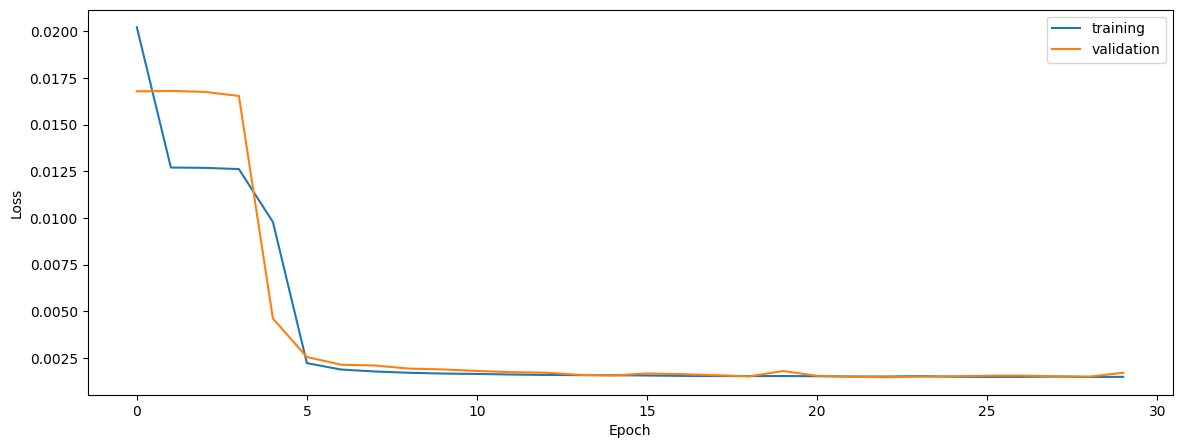

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.938886837536919
0.9548843591930506
0.9224365963335692


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.938886837536919
0.9548843591930506
0.9224365963335692


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.944622956186637
0.9578248354530209
0.9358506991243022


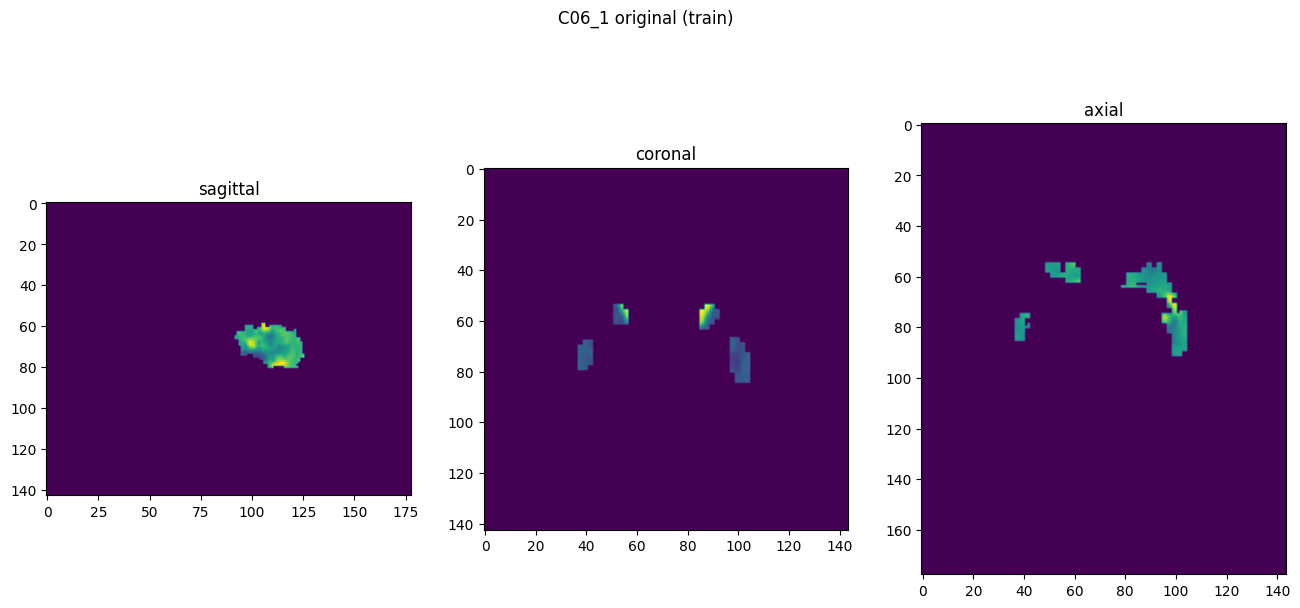

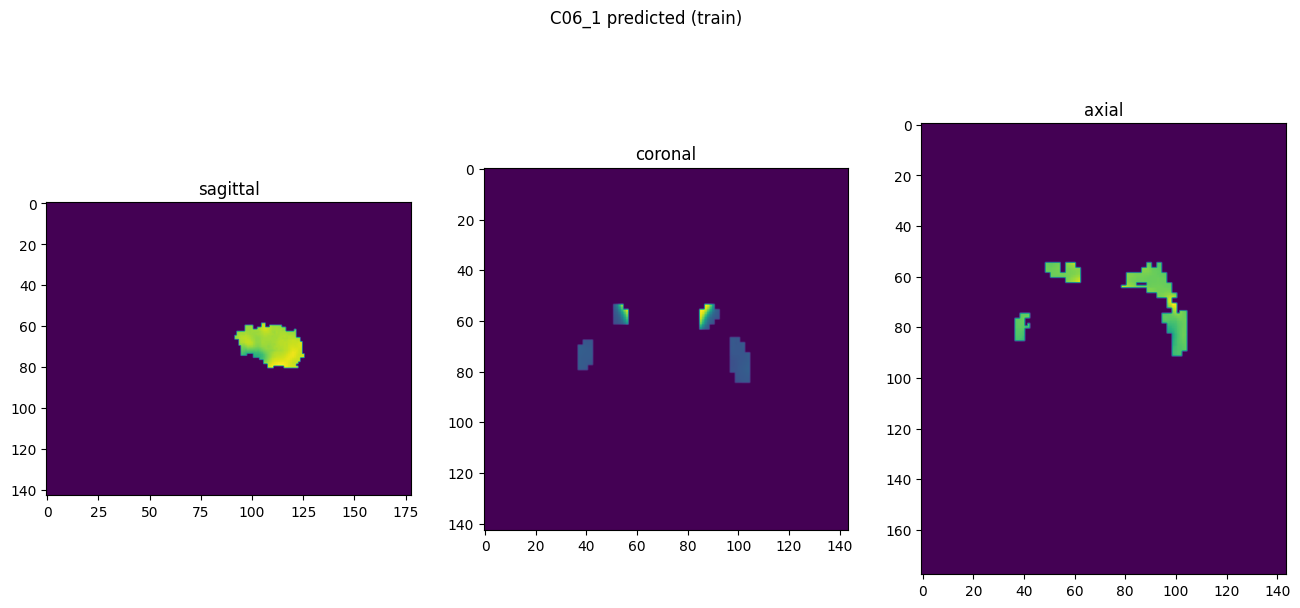

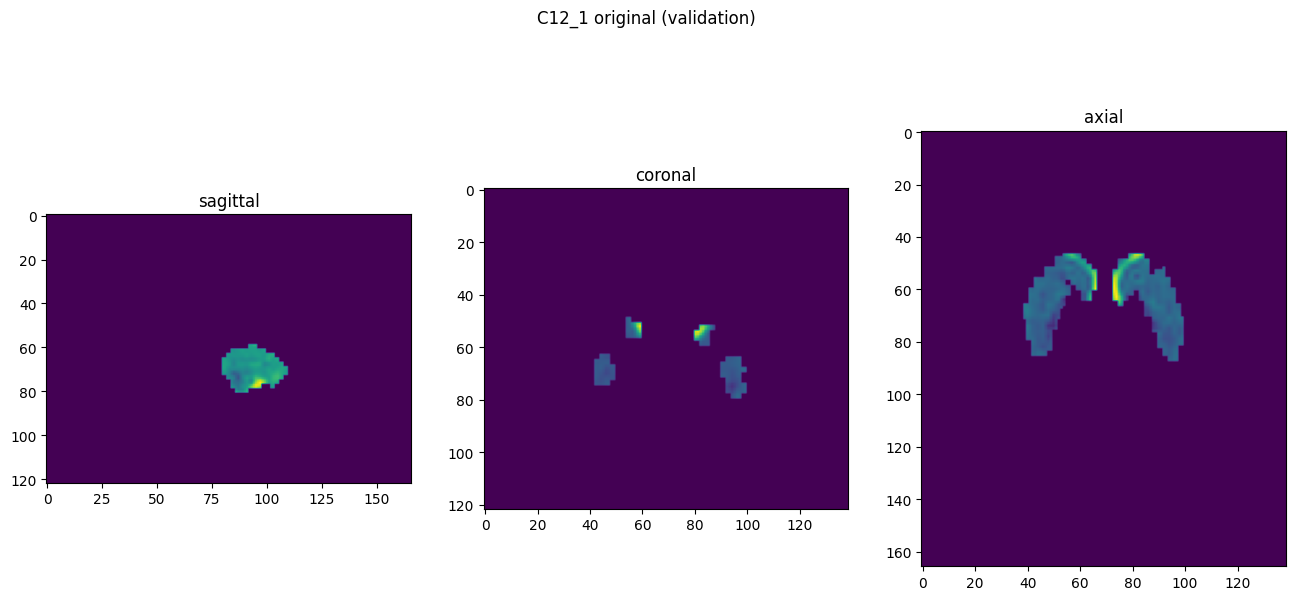

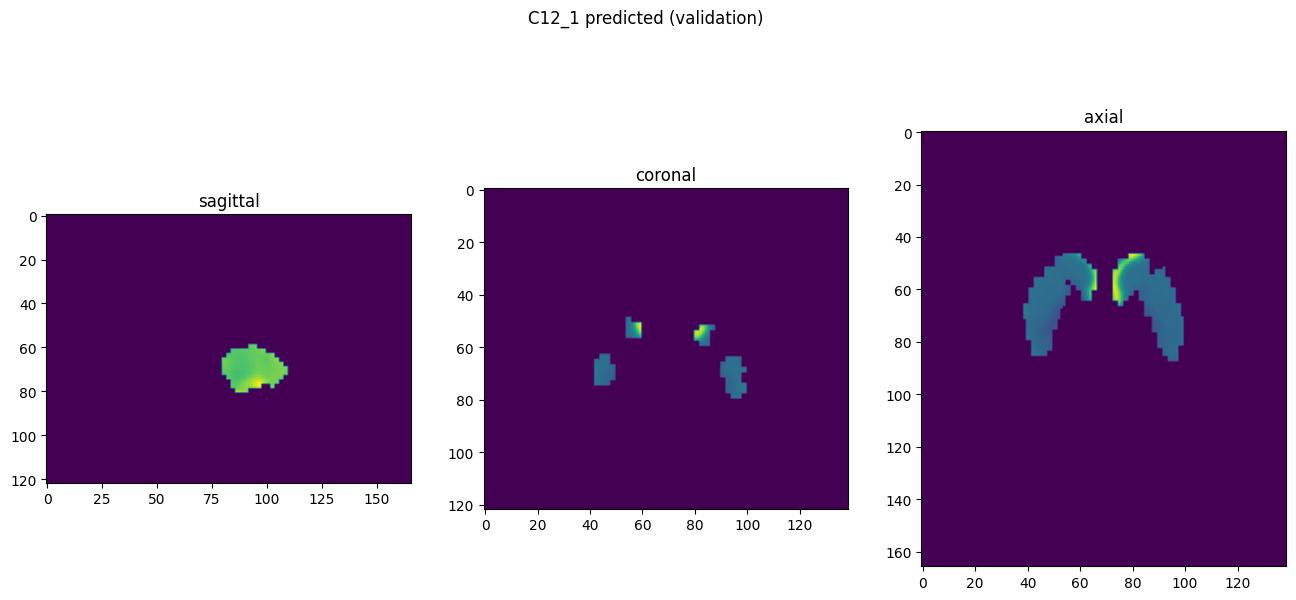

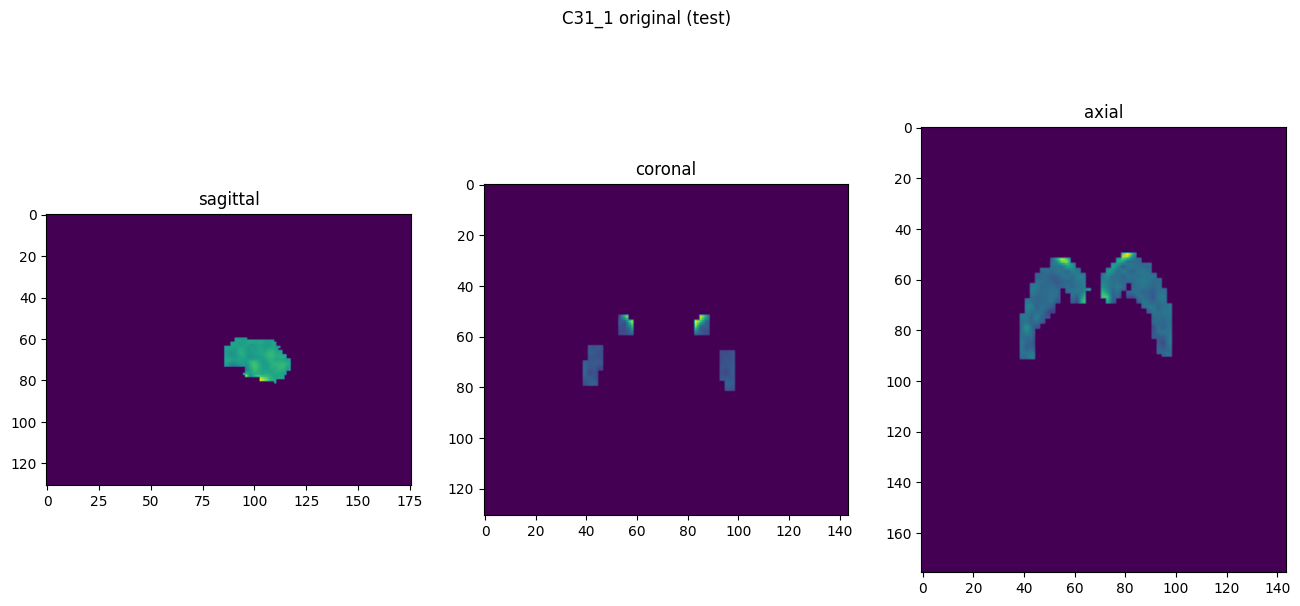

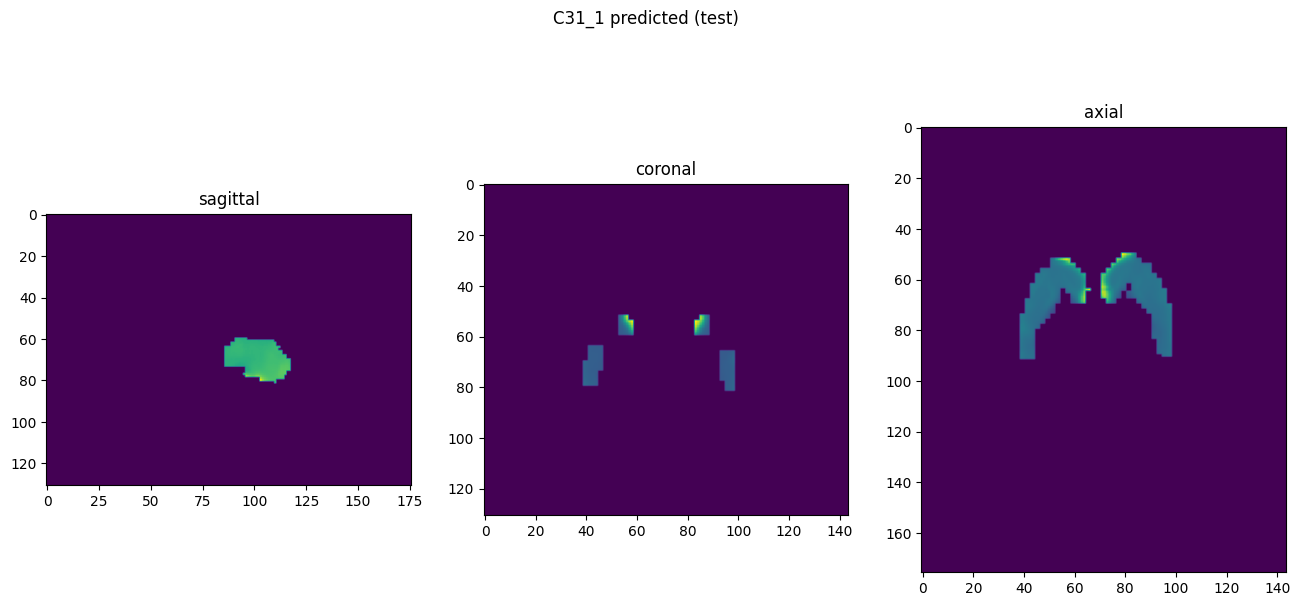

In [10]:
showResults(model, gen, threshold=None, background=False)